## Bistable Solution as found in 2016 paper by Sharma and Roberts

In [16]:
# import modules
%reset
import numpy as np
import matplotlib.pyplot as plt
import random
import scipy.integrate as snt
from decimal import Decimal
from matplotlib.colors import LogNorm

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [24]:
## define constants and model (using model 2 as described in Sharma & Roberts paper)

## SPECIES
    # R (receptor on cell surface)
    # L (ligand ~alpha factor)
    # RL (receptor-ligand complex)
    # K (kinase in MAPK pathway to propogate signal)
    # Kp (singly phosphorylated kinase)
    # Kpp (doubly phosphorylated kinase)
    # P (phosphatase to remove phosphates from kinases)
# mass balance laws:
    # Ktot = K + Kp + Kpp
    
## REACTIONS
    # RL -> R + L                c5
    # K + K -> K + Kp           2c1
    # Kp + K -> Kp + Kp         2c2
    # P + Kp -> P + K            c0
    # R + L -> RL                c4
    # RL + K -> RL + Kp          c6
    # K + Kp -> K + Kpp          c1
    # Kp + Kp -> Kp + Kpp        c2
    # Kpp + K -> Kpp + Kp       2c3
    # Kpp + Kp -> Kpp + Kpp      c3
    # P + Kpp -> P + Kp         2c0

## KINETIC RATE LAWS
    # dK/dt   = -c0*S*K - 2*c1*K**2 - 2*c2*K*Kp - 2*c3*K*Kpp + c4*Kp*P
    # dKp/dt  = c0*S*K + 2*c1*K**2 + 2*c2*Kp*K - c2*Kp**2 - c3*Kp*Kpp + 2*c3*Kpp*K + 2*c4*Kpp*P - c4*Kp*P
    # dKpp/dt = c2*Kp**2 + c3*Kpp*Kp - 2*c4*Kpp*P

# DEFINE CONSTANTS
Ktot = 1
P = 0.25
R0 = 1.6;
L0 = 4;

    
## DEFINE RATES THAT ARE NOT BEING VARIED
c0 = 5
# c1 can vary
# c2 can vary
c3 = 5
c4 = 10
c5 = 10
c6 = 0.1

## DEFINE RANGE AT WHICH OTHER RATES MAY VARY
n = 35
rateRange = np.linspace(1e-2, 1, n)

## reaction matrix (to make defining the ODEs easier)
    #        K*K       Kp*K      P*Kp  RL*K    Kp*Kp    Kpp*Kp    Kpp*K       P*Kpp
    # dK    -2*c1     -2*c2       c0   -c6       0        0      -2*c3          0
    # dKp    2*c1   -c1 + 2*c2   -c0    c6     -c2       -c3      2*c3         2*c0
    # dKpp    0         c1         0     0      c2        c3       0          -2*c0       

    
## define ODEs, don't need reaction rates c4 or c5 (used in determination of RLss)
#  st y = [K, Kp, Kpp]
def rates(y, t, c0, c1, c2, c3, c6, RL, P):
    return np.asarray([-2*c1*y[0]**2 -2*c2*y[1]*y[0] + c0*y[1]*P -c6*RL*y[0] -2*c3*y[2]*y[0],
                       2*c1*y[0]**2 + (-c1 + 2*c2)*y[1]*y[0] -c0*P*y[1] + c6*RL*y[0] -c2*y[1]**2 -c3*y[2]*y[1] + 2*c3*y[2]*y[0] + 2*c0*P*y[2],
                       c1*y[1]*y[0] + c2*y[1]**2  + c3*y[2]*y[1] -2*c0*P*y[2]
                      ])

In [25]:
params = {}

#there should be paramRange^params columns so in our case len(paramRange)^nReac
cols = len(rateRange)**2 # since we are only varying 2 rates

params['c0'] = np.ones(cols)*c0
params['c1'] = np.zeros(cols)
params['c2'] = np.zeros(cols)
params['c3'] = np.ones(cols)*c3
params['c4'] = np.ones(cols)*c4
params['c5'] = np.ones(cols)*c5
params['c6'] = np.ones(cols)*c6

keys = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6']

In [26]:
# set the varying kinetic rate constants for c1 and c2
iter = 0
for par in [1, 2]:
    indStart = 0
    while indStart < cols:
        val = 0
        while val < len(rateRange):
            indEnd = indStart + len(rateRange)**(iter)
            params[keys[par]][indStart:indEnd] = rateRange[val]
            val += 1
            indStart = indEnd
    iter = iter + 1

In [27]:
## determine RLss (set dRL/dt to 0 and solve for RL)
RL = []
RL.append(-(c5 + c4*(R0+L0)) + np.sqrt((c5 + c4*(R0+L0))**2 - 4*R0*L0*(c4)**2))
RL.append(-(c5 + c4*(R0+L0)) - np.sqrt((c5 + c4*(R0+L0))**2 - 4*R0*L0*(c4)**2))
RL = np.asarray(RL)/(-2*c4)
if (RL.all() < 0):
    print 'there are no real solutions for the steady state solution for RL'
elif (RL[0] > 0 and RL[1] < 0):
    print 'there is 1 solution for RLss: ' + str(RL[0])
    RL = RL[0]
elif (RL[0] < 0 and RL[1] > 0):
    print 'there is 1 solution for RLss: ' + str(RL[1])
    RL = RL[1]
else:
    print 'there are 2 real solutions for the steady state, redo the following analyis by switching the following code from RL[0] to RL[1] to see other solution'
    RL = RL[0]
    print 'the RLss is ' + str(RL)

there are 2 real solutions for the steady state, redo the following analyis by switching the following code from RL[0] to RL[1] to see other solution
the RLss is 1.18103798996


In [28]:
tol = 1e-3
Ktot = 1
P = 0.25
Kp = np.linspace(0,Ktot,float(n)/2)
Kpp = np.linspace(0,Ktot,float(n)/2)

diff = {}
val = 0
acc = []
for iter in range(len(params['c0'])):
    c0 = params['c0'][iter]
    c1 = params['c1'][iter]
    c2 = params['c2'][iter]
    c3 = params['c3'][iter]
    c4 = params['c4'][iter]
    c5= params['c5'][iter]
    c6 = params['c6'][iter]
    #append to differential space
    A = np.matrix(np.asarray([
              -2*c1,     -2*c2,       c0,   -c6,       0,        0,      -2*c3,          0,
               2*c1,   -c1 + 2*c2,   -c0,    c6,     -c2,       -c3,      2*c3,         2*c0,
                  0,       c1,         0,     0,      c2,        c3,       0,          -2*c0       ]).reshape([3,8]))
    #find individual kinase differentials
    dk = np.ones(len(Kp)*len(Kpp)).reshape([len(Kpp), len(Kp)])*10
    dkp = np.ones(len(Kp)*len(Kpp)).reshape([len(Kpp), len(Kp)])*10
    dkpp = np.ones(len(Kp)*len(Kpp)).reshape([len(Kpp), len(Kp)])*10
    k = []
    for i in range(len(Kp)):
        for j in range(len(Kpp)):
            K = Ktot - Kp[i] - Kpp[j]
            if K >= 0:
                dk[i,j] = np.power(A.dot(np.asarray([K*K, Kp[i]*K, P*Kp[i], RL*K, Kp[i]*Kp[i], Kpp[j]*Kp[i], Kpp[j]*K, P*Kpp[j]]).reshape([8,1])),2)[0]
                dkp[i,j] = np.power(A.dot(np.asarray([K*K, Kp[i]*K, P*Kp[i], RL*K, Kp[i]*Kp[i], Kpp[j]*Kp[i], Kpp[j]*K, P*Kpp[j]]).reshape([8,1])),2)[1]
                dkpp[i,j] = np.power(A.dot(np.asarray([K*K, Kp[i]*K, P*Kp[i], RL*K, Kp[i]*Kp[i], Kpp[j]*Kp[i], Kpp[j]*K, P*Kpp[j]]).reshape([8,1])),2)[2]
    grad = dk + dkp + dkpp
    if (sum(sum(grad <= tol))>=3):
        val = val + 1
        print sum(sum(grad<=tol)), 'at index', iter, 'of', len(params['c0'])
        diff[val] = {}
        diff[val]['dk'] = dk
        diff[val]['dkp'] = dkp
        diff[val]['dkpp'] = dkpp
        acc.append(iter)
    if ((float(iter)/len(params['c0'])*100 % 10) == 0):
        print float(iter)/len(params['c0'])*100, '%'
        
print 'done'

0.0 %
3 at index 1 of 1225
3 at index 2 of 1225
3 at index 3 of 1225
4 at index 36 of 1225
20.0 %
40.0 %
60.0 %
80.0 %
done


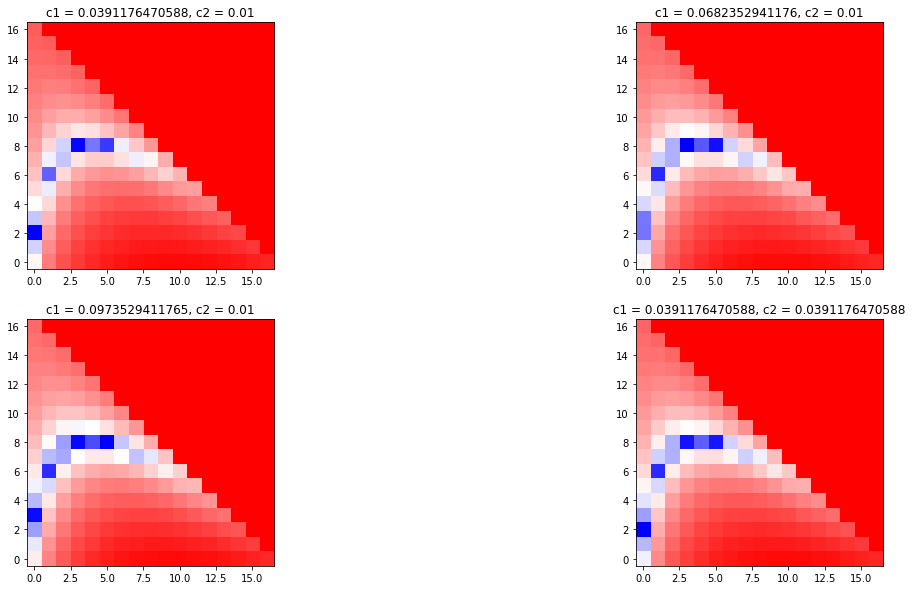

In [29]:
#plot accepted values
fig = plt.figure(figsize=(20,10))
ind = 1

ncol = 2
rows = np.ceil(float(len(acc))/ncol)
for i in range(1,len(diff)+1):
    ax = fig.add_subplot(rows,ncol,ind)
    plt.imshow(np.log(diff[i]['dk']+diff[i]['dkp']+diff[i]['dkpp']), cmap = 'bwr', origin = 'lower')
    ax.set_title(', '.join(['c1 = ' + str(params['c1'][acc[i-1]]), 'c2 = ' + str(params['c2'][acc[i-1]])]))
    #plt.colorbar()
    ind = ind + 1
    
plt.show()

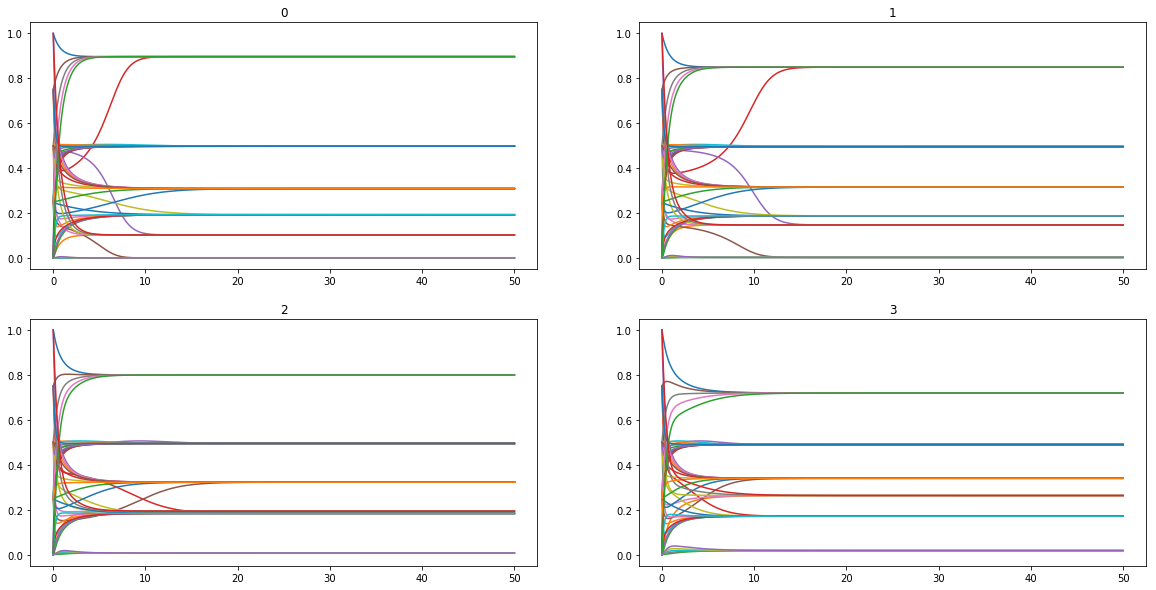

In [31]:
### see if kp, kpp combinations close to stable solution converge to stable solution
fig = plt.figure(figsize=(20,10))
S = 10

N = 1000
t = np.linspace(0,50, N)
vals = 10

inits = {}
iter = 0
Kp = np.linspace(0,1,5)
Kpp = Kp
for i in range(len(Kp)):
    for j in range(len(Kpp)):
        K = Ktot - Kp[i] - Kpp[j]
        if K >= 0:
            inits[iter] = [Ktot - Kp[i] - Kpp[j], Kp[i], Kpp[j]]
            iter = iter + 1

for iter in range(len(acc)):
    ode = {}
    for i in inits.keys():
        y0 = inits[i]
        paramsTemp = [params['c0'][acc[iter]], params['c1'][iter], params['c2'][acc[iter]], params['c3'][acc[iter]], params['c6'][acc[iter]], RL, P]
        odeTemp = snt.odeint(rates, y0,t, args = tuple(paramsTemp))
        ode[i] = []
        ode[i] = odeTemp
    ax = fig.add_subplot(rows,ncol,iter+1)
    for i in ode.keys():
        for j in range(np.shape(ode[i])[1]):
            plt.plot(t, ode[i][:,j][0:N])
    ax.set_title(iter)


plt.show()

5.0 0.0973529411765 0.01 5.0 0.1


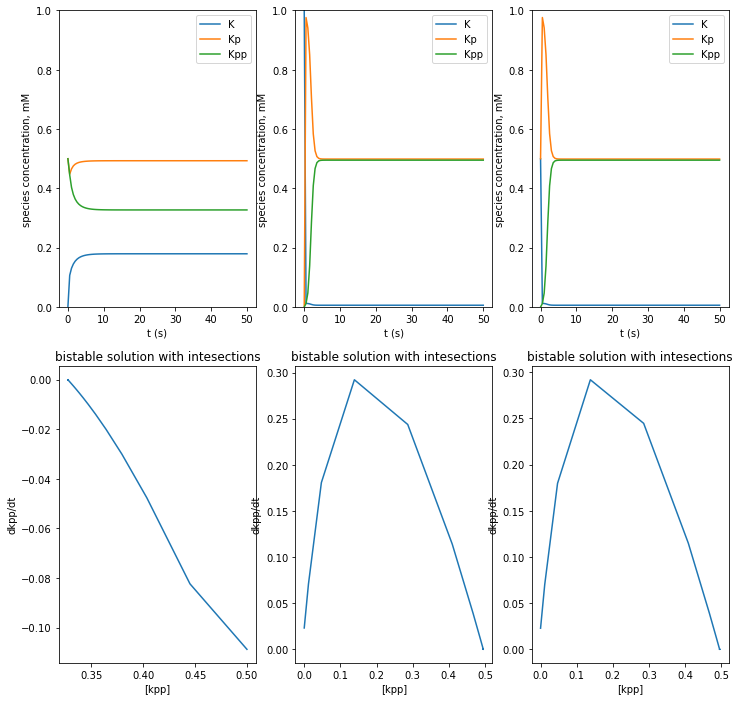

In [35]:
T = 50
att = 2

print params['c0'][acc[att]], params['c1'][acc[att]], params['c2'][acc[att]], params['c3'][acc[att]], params['c6'][acc[att]]
#initial concentrations
s2 = 0
s3 = .5*Ktot
s4 = .5*Ktot

V =1
y0 = np.asarray([s2, s3, s4])/V #initial species concentration

n = 100
t = np.linspace(0,T,n)
ode = snt.odeint(rates, y0,t, args = (params['c0'][acc[att]], params['c1'][acc[att]], params['c2'][acc[att]], params['c3'][acc[att]], params['c6'][acc[att]], RL, P))

#find dkpp/dt
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(2,3,4)
dkpp = np.diff(ode[:,2])/np.diff(t)
ax.plot(ode[:,2][0:n-1],dkpp)
ax.set_title('bistable solution with intesections')
ax.set_xlabel('[kpp]')
ax.set_ylabel('dkpp/dt')


ax = fig.add_subplot(2,3,1)
for i in range(len(y0)):
    ax.plot(t, ode[:,i][0:n])
ax.set_xlabel('t (s)')
#plt.title(''.join(['[S] = ', str(c1)]))
ax.set_ylabel('species concentration, mM')
ax.legend(['K', 'Kp', 'Kpp'])
ax.set_ylim([0,Ktot])

# plot another solution
#initial concentrations
s2 = Ktot 
s3 = 0
s4 = 0

V =1
y0 = np.asarray([s2, s3, s4])/V #initial species concentration

n = 100
t = np.linspace(0,T,n)
ode = snt.odeint(rates, y0,t, args = (params['c0'][acc[att]], params['c1'][acc[att]], params['c2'][acc[att]], params['c3'][acc[att]], params['c4'][acc[att]], S, P))

#find dkpp/dt
ax = fig.add_subplot(2,3,5)
dkpp = np.diff(ode[:,2])/np.diff(t)
ax.plot(ode[:,2][0:n-1],dkpp)
ax.set_title('bistable solution with intesections')
ax.set_xlabel('[kpp]')
ax.set_ylabel('dkpp/dt')


ax = fig.add_subplot(2,3,2)
for i in range(len(y0)):
    ax.plot(t, ode[:,i][0:n])
ax.set_xlabel('t (s)')
#plt.title(''.join(['[S] = ', str(c1)]))
ax.set_ylabel('species concentration, mM')
ax.legend(['K', 'Kp', 'Kpp'])
ax.set_ylim([0,Ktot])

# plot another solution
#initial concentrations
s2 = .5*Ktot
s3 = .5*Ktot 
s4 = 0

V =1
y0 = np.asarray([s2, s3, s4])/V #initial species concentration

n = 100
t = np.linspace(0,T,n)
ode = snt.odeint(rates, y0,t, args = (params['c0'][acc[att]], params['c1'][acc[att]], params['c2'][acc[att]], params['c3'][acc[att]], params['c4'][acc[att]], S, P))

#find dkpp/dt
ax = fig.add_subplot(2,3,6)
dkpp = np.diff(ode[:,2])/np.diff(t)
ax.plot(ode[:,2][0:n-1],dkpp)
ax.set_title('bistable solution with intesections')
ax.set_xlabel('[kpp]')
ax.set_ylabel('dkpp/dt')


ax = fig.add_subplot(2,3,3)
for i in range(len(y0)):
    ax.plot(t, ode[:,i][0:n])
ax.set_xlabel('t (s)')
#plt.title(''.join(['[S] = ', str(c1)]))
ax.set_ylabel('species concentration, mM')
ax.legend(['K', 'Kp', 'Kpp'])
ax.set_ylim([0,Ktot])


plt.show()